In [1]:
# -*- coding: UTF-8 -*-
from utils import *
from numpy.random import shuffle, choice, normal
from numpy import array, reshape, mean
from cacheout.lfu import LFUCache
from cacheout.lru import LRUCache
import time, gc
from collections import Counter
from pandas import DataFrame
import matplotlib.pyplot as plt
from copy import deepcopy
import multiprocessing

In [15]:
rg = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]

class CocktailModel:
    """
    given a distribution and a trace,
    given the pre-fixed settings of a cache,
    provide the calculated hit rate
    """

    def __init__(self, trace_in_period, cacheSize, history_importance=0.5, globle_file_range=100):
        """
        construct a cocktail model based on the given request pattern in a fixed period of time
        """
        self.cacheSize = cacheSize
        self.history_freq_dict = {}
        self.history_importance = history_importance
        self.bartending_cocktail(trace_in_period)
        self.history_hit_rate = cacheSize / globle_file_range
        self.history_miss = 0
        self.req_count = 0

    def moving_average_for_freq(self, freq_dict, history_freq_dict):
        X, Y = Counter(freq_dict), Counter(history_freq_dict)
        self.history_freq_dict = dict(X + Y)

    def featCacheSize(self):
        """
        find and return kth level index ---- k
        """
        virtualCacheSize = 0
        sortedBucket = sorted(self.bucket.items(), key=lambda x: x[0], reverse=True)
        for item in sortedBucket:
            virtualCacheSize += len(item[1])
            if virtualCacheSize >= self.cacheSize:
                # this indicates that <the recurrence item[0]> is <the k level>
                # (the k th level is most susceptible to replacement)
                return item[0]
        return 0  # None

    def bartending_cocktail(self, trace_in_period):
        self.period_freq_dict = freq_dict = count_freq(trace_in_period)
        self.moving_average_for_freq(freq_dict, self.history_freq_dict)
        self.bucket = cluster_by_freq(self.history_freq_dict)
        self.surface_level_freq = self.featCacheSize()

    def calculate_hitrate_theo(self, distribution='absolute order', params=None):
        """
        provide a quick formula for calculation of hit rate
        """
        self.req_count += 50
        if distribution == 'absolute order':
            if not self.surface_level_freq:
                miss = 0
            else:
                miss = len([k for k, v in self.period_freq_dict.items() if v == self.surface_level_freq])
            self.history_hit_rate = 0.5 * (self.history_hit_rate + (1 - miss / 50))  # serious bug
            return self.history_hit_rate
        elif distribution == 'sim':
            if not self.surface_level_freq:
                miss = 0  # should be the prob that the requested item is in cache * 50
            else:
                # miss = len([k for k, v in self.period_freq_dict.items() if v <= self.surface_level_freq])
                losers = [k for k, v in self.period_freq_dict.items() if v <= self.surface_level_freq]
                miss = sum([int(i in losers) for i in period_trace])
            self.history_miss += miss
            self.history_hit_rate = 1 - self.history_miss / self.req_count
            return self.history_hit_rate
        elif distribution == 'exp':
            pass
        elif distribution == 'zipf':
            pass


class RealCache:
    """
    create a realCache using the 'cacheout' lib
    """

    def __init__(self, cacheSize, policy='LFU'):
        if policy == 'LFU':
            self.cache = LFUCache(maxsize=cacheSize, ttl=0, timer=time.time, default=None)
        elif policy == 'LRU':
            self.cache = LRUCache(maxsize=cacheSize, ttl=0, timer=time.time, default=None)
        self.hit, self.miss = 0, 0

    def handle_request(self, req):
        if self.cache._has(req):
            self.hit += 1
        else:
            self.cache._add(req, 1)
            self.miss += 1

    def hit_rate(self, trace):
        """
        return hit rate for trace
        """
        for req in trace:
            self.handle_request(req)
        return self.hit / (self.hit + self.miss + 0.01)  # hit rate

-0.11787985860805658
-0.19019980361607863
-0.23949975585609767
0.016680270527891672
-7.969996812007274e-05
0.008200316719873313
-0.025079649968140272
-0.03987962404815015
-0.030759607696157265


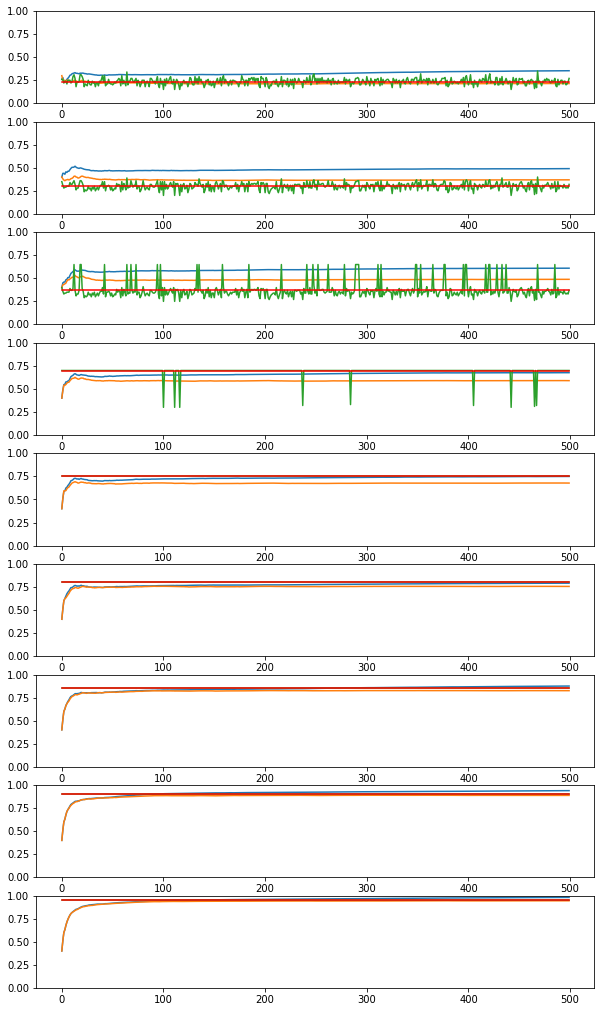

In [22]:
%matplotlib inline
# plt.ion()
num_stages = 500
file_range = 100
traceGenerator = TraceGenerator(50)
trace = [traceGenerator.generate_zipf(n=file_range, alpha=0.7, num_samples=50) for i in range(num_stages)]
plt.figure(figsize=(10, 20))

# print('zipf: n=100, alpha=0.7, num_samples=50')

# trace = [traceGenerator.generate_exponential(scale=15) for i in range(num_stages)]
# print('exp: n=100, scale=10')

# trace = [list(traceGenerator.generate_normal(sigma=15)) for i in range(num_stages)]
# print('normal: mu=0, sigma=25')

# lst = []
# st = set()
# for t in trace:
#     st = st | set(t)
#     lst.append(len(st))  # count the unique elements in trace
# print(lst)

for cache_Size in range(10, 100, 10):
    global_plot_record = {'lfu': [], 'lru': [],
                          # 0.: [], 0.1: [], 0.2: [], 0.3: [], 0.4: [], 0.5: [], 0.6: [],
                          # 0.7: [], 0.8: [], 0.9: [], 1: [],
                          'cocktail': []}
    real_cache_lfu = RealCache(cache_Size, 'LFU')
    real_cache_lru = RealCache(cache_Size, 'LRU')

    last_cocktail = None
    cocktails = None
    kth_level = []

    for period_trace in trace:
        cocktail = CocktailModel(period_trace, cache_Size, globle_file_range=file_range)  # if zipf
        global_plot_record['lfu'].append(real_cache_lfu.hit_rate(period_trace))
        global_plot_record['lru'].append(real_cache_lru.hit_rate(period_trace))
        cocktail.bartending_cocktail(period_trace)
        global_plot_record['cocktail'].append(cocktail.calculate_hitrate_theo())
        kth_level.append(cocktail.surface_level_freq)

    # print('cache_Size:', cache_Size, global_plot_record['cocktail'])
    # print('bucket', cocktail.bucket)
    # print('kth_level', kth_level)
    # print([i for i in zip(global_plot_record['cocktail'], kth_level)])

#     plt.subplot(16, 1, (cache_Size-8) // 2)
    plt.subplot(10, 1, cache_Size // 10)
    for i in global_plot_record:
        plt.plot(global_plot_record[i])
    m = mean(global_plot_record['cocktail'])
    plt.ylim(0, 1)
    print(m - global_plot_record['lfu'][-1])
    plt.plot([0, 499], [m, m], c='r')
    # plt.pause(3)
    # gc.collect()
# plt.ioff()
plt.show()